In [ ]:
!unzip /content/A.zip

In [1]:
# initialization
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
import os
drive.mount('/content/drive')
import numpy as np
import time
import pandas as pd
from matplotlib.image import imread
from torchvision.io import read_image
from torchsummary import summary
import torch.optim as optim

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# path declare
master_path = '/content/drive/MyDrive/APS360Project/archive/cropped_dataset/'
csv_path = master_path + "cropped_proportion.csv"
train_csv_path = master_path + "cropped_proportion_train.csv"
val_csv_path = master_path + "cropped_proportion_valid.csv"
test_csv_path = master_path + "cropped_proportion_test.csv"
class_dict_path = master_path + "class_dict.csv"
image_folder_path = '/content/A'
transform = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
         transforms.Resize((256,256))])

total_info = pd.read_csv(csv_path)
train_info = pd.read_csv(train_csv_path)
val_info = pd.read_csv(val_csv_path)
test_info = pd.read_csv(test_csv_path)

In [3]:
print(len(total_info['image_id']))
print(len(train_info['image_id']), len(train_info['image_id'])/len(total_info['image_id']))
print(len(val_info['image_id']), len(val_info['image_id'])/len(total_info['image_id']))
print(len(test_info['image_id']), len(test_info['image_id'])/len(total_info['image_id']))

12848
9616 0.7484433374844334
1616 0.12577833125778332
1616 0.12577833125778332


In [4]:
classes = pd.read_csv(class_dict_path)
list(classes['name'])

['urban_land',
 'agriculture_land',
 'rangeland',
 'forest_land',
 'water',
 'barren_land',
 'unknown']

In [5]:
# customed dataset for load in data
class data_full(object):
    def __init__(self, csv_info, class_dict_path, image_folder_path, transform):
      self.img_info = csv_info
      self.image_folder_path = image_folder_path
      self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def getitem(self, i):
        img_path = os.path.join(self.image_folder_path, self.img_info['sat_image_path'][i])
        image = read_image(img_path)
        label = [self.img_info['urban_land'][i], self.img_info['agriculture_land'][i], self.img_info['rangeland'][i],
                 self.img_info['forest_land'][i], self.img_info['water'][i], self.img_info['barren_land'][i],
                 self.img_info['unknown'][i]]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# load to each set
train_set = []
val_set = []
test_set = []

train_dataset = data_full(train_info, class_dict_path, image_folder_path ,transform=transform)
val_dataset = data_full(val_info, class_dict_path, image_folder_path ,transform=transform)
test_dataset = data_full(test_info, class_dict_path, image_folder_path ,transform=transform)

for i in range(int(len(train_info['image_id'])/4)):
  image, label = train_dataset.getitem(i)
  train_set.append((image, label))
  print(i)
print("finish val set")

In [ ]:
class CustomDataset(object):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Dummy data and targets
data = torch.randn(100, 3, 32, 32)  # Example: 100 samples of 3-channel images with size 32x32
targets = torch.randint(0, 10, (100,))  # Example: Random integer labels between 0 and 9

# Create a custom dataset instance
dataset = CustomDataset(data, targets)

# Create a data loader
batch_size = 32
shuffle = True
num_workers = 4  # Number of subprocesses to use for data loading
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=shuffle, num_workers=num_workers)

# Iterate over batches in the data loader
for batch_idx, (inputs, labels) in enumerate(data_loader):
    print(inputs, labels)
    if batch_idx == 0:
      break


In [8]:
for i in range(int(len(val_info['image_id'])/4)):
  image, label = val_dataset.getitem(i)
  val_set.append((image, label))
print("finish val set")

for i in range(int(len(test_info['image_id'])/4)):
  image, label = test_dataset.getitem(i)
  test_set.append((image, label))
print("finish test set")

finish val set
finish test set


In [32]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1 ,
                                            shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)

In [33]:
def model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_training_curve(path):
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

#plt curve

In [40]:
def calculate_accuracy(net, loader, criterion):
    correct = 0
    total = 0
    total_loss = 0.0
    net_eval = net.eval()
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net_eval(inputs).T
        pred = outputs
        labels = torch.stack(labels)
        labels = labels.double()
        outputs = outputs.double()
        correct += pred.eq((labels.view(-1)).view_as(pred)).sum().item()
        #print("labels:", labels, "predication:",pred)
        total += inputs.shape[0]
        loss = criterion(outputs, labels)
        total_loss += loss.item()

    #print(correct, total)
    correct = correct/7
    accuracy = correct / total
    loss = float(total_loss) / (len(loader))
    return accuracy, loss

In [ ]:
model = ANN()
calculate_accuracy(model, val_loader, torch.nn.BCELoss())

In [11]:
def train_net1(net, learning_rate=None, num_epochs=None, train_loader = None, val_loader = None, test_loader = None):
    target_classes = ['urban_land',
                      'agriculture_land',
                      'rangeland',
                      'forest_land',
                      'water',
                      'barren_land',
                      'unknown']
    torch.manual_seed(1000) #duplicate result or not -> set seeds random number generators
    criterion = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    print("Training Start:")
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            #print(data.shape())
            [[inputs, labels]] = data
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            #print(outputs)
            for l in labels:
              l = l.detach().numpy()
            print(type(labels), type(labels[0]), type(outputs))
            loss = criterion(labels, outputs)
            loss.backward()
            optimizer.step()

        train_err[epoch], train_loss[epoch] = calculate_accuracy(net, train_loader, criterion)
        val_err[epoch], val_loss[epoch] = calculate_accuracy(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = model_name(net.name, batch_size, learning_rate, epoch)
        # torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    #new_dir = pathlib.Path('/content/', trail)
    #new_dir.mkdir(parents=True, exist_ok=True)
    # You have to make a file inside the new directory
    #new_file = new_dir / "{}_train_err.csv".format(model_path)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [22]:
def train_net(net, learning_rate=None, num_epochs=None, train_loader=None, val_loader=None, test_loader=None):
    target_classes = ['urban_land',
                      'agriculture_land',
                      'rangeland',
                      'forest_land',
                      'water',
                      'barren_land',
                      'unknown']
    torch.manual_seed(1000)  # Duplicate result or not -> set seeds random number generators
    criterion = torch.nn.BCELoss()  # Binary Cross Entropy Loss in PyTorch
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    print("Training Start:")
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            optimizer.zero_grad()
            # Get the inputs and labels
            inputs = data[0]  # Features tensor
            label_probs = data[1]  # Label probabilities list
            labels = torch.stack(label_probs)
            labels = torch.tensor(labels, requires_grad=False)  # Convert label probabilities to PyTorch tensor
            # Forward pass, backward pass, and optimize
            outputs = net(inputs).T
            #print(outputs)
            labels = labels.double()
            outputs = outputs.double()
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            #print(loss)
            loss.backward()
            optimizer.step()

        train_err[epoch], train_loss[epoch] = calculate_accuracy(net, train_loader, criterion)
        val_err[epoch], val_loss[epoch] = calculate_accuracy(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |" +
               "Validation err: {}, Validation loss: {}").format(
            epoch + 1,
            train_err[epoch],
            train_loss[epoch],
            val_err[epoch],
            val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = model_name(net.name, batch_size, learning_rate, epoch)
        # torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.name = "1.0"
        self.conv1 = nn.Conv2d(3, 16, 12, stride=4, padding=4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 6, stride=2, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=2)
        self.fc1 = nn.Linear(4 * 4 * 64, 32)
        self.fc2 = nn.Linear(32, 7)

    def forward(self, x):
        x = F.Sigmoid(self.conv1(x)) # 256 -> 64 -> 32
        #print(x.shape)
        x = self.pool(x) # 64 -> 32
        #print(x.shape)
        x = F.Sigmoid(self.conv2(x)) # 32 -> 16
        #print(x.shape)
        x = self.pool(F.Sigmoid(self.conv3(x))) # 16 -> 10 -> 4
        #print(x.shape)
        x = x.view(-1, 4 * 4 * 64)
        #print(x.shape)
        x = F.Sigmoid(self.fc1(x))
        #print(x.shape)
        x = F.Sigmoid(self.fc2(x))
        #print(x.shape)
        #x = x.squeeze(1)
        #x = F.softmax(x)
        return x

In [ ]:
model = CNN1()
#summary(model, (3, 256, 256))
train_net(model, learning_rate=0.002, num_epochs=20, train_loader = train_loader, val_loader = val_loader, test_loader = test_loader)
model_path = model_name("1.0", batch_size=64, learning_rate=0.002, epoch=19)
plot_training_curve(model_path)

In [ ]:
for i, data in enumerate(train_loader, 0):
    if i > 0:
        break
    print(data)

In [15]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ANN"
        self.layer1 = nn.Linear(256*256*3, 256)
        self.layer2 = nn.Linear(256, 64)
        self.layer3 = nn.Linear(64, 7)

    def forward(self, x):
        flattened = x.view(x.size(0), -1)
        activation = self.layer1(flattened)
        activation = F.relu(activation)
        activation = self.layer2(activation)
        activation = self.layer3(activation)
        activation = F.relu(activation)
        x = activation.squeeze(1) # Flatten to [batch_size]
        return F.softmax(x)

In [42]:
model = ANN()
train_net(model, learning_rate=0.002, num_epochs=10, train_loader = train_loader, val_loader = val_loader, test_loader = test_loader)
model_path = model_name("ANN", batch_size=64, learning_rate=0.002, epoch=9)
plot_training_curve(model_path)

Training Start:


<ipython-input-22-eea1b2f595bd>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, requires_grad=False)  # Convert label probabilities to PyTorch tensor
<ipython-input-15-3bd59bb2fca5>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 1: Train err: 0.6912883289755171, Train loss: 12.042479928988882 |Validation err: 0.6679632248939179, Validation loss: 13.889070795068488
Epoch 2: Train err: 0.6912883289755171, Train loss: 12.042682487233778 |Validation err: 0.6679632248939179, Validation loss: 13.669623727654292
Epoch 3: Train err: 0.6912883289755171, Train loss: 12.042682487233778 |Validation err: 0.6679632248939179, Validation loss: 13.947778447309876
Epoch 4: Train err: 0.6912883289755171, Train loss: 12.042682487233778 |Validation err: 0.6679632248939179, Validation loss: 14.061509601536272
Epoch 5: Train err: 0.6912883289755171, Train loss: 12.042682487233778 |Validation err: 0.6679632248939179, Validation loss: 13.936508149220803
Epoch 6: Train err: 0.6912883289755171, Train loss: 12.042682486675377 |Validation err: 0.6679632248939179, Validation loss: 14.081615918950119
Epoch 7: Train err: 0.6912883289755171, Train loss: 12.042682486675377 |Validation err: 0.6679632248939179, Validation loss: 14.05604526

FileNotFoundError: model_ANN_bs64_lr0.002_epoch9_train_err.csv not found.

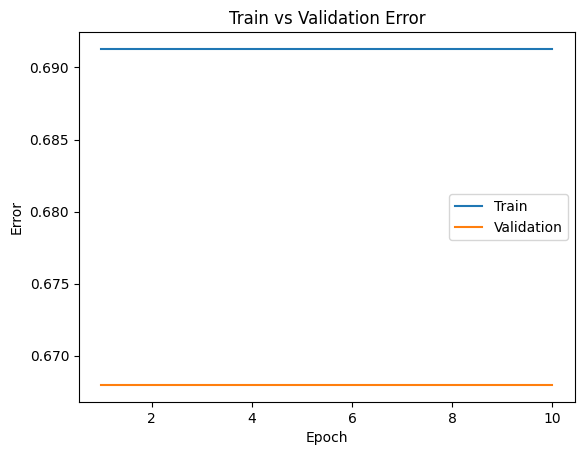

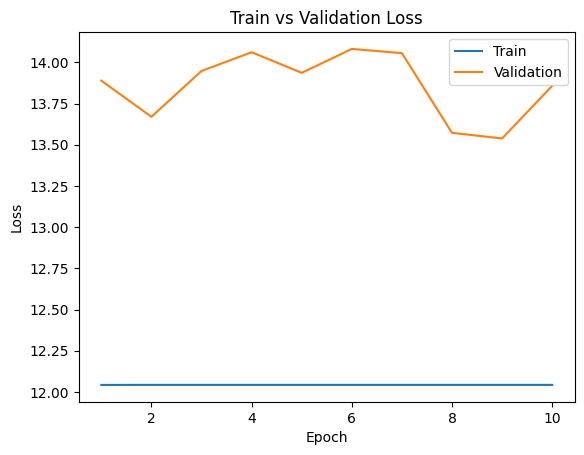

In [43]:
model_path = model_name("ANN", batch_size=16, learning_rate=0.002, epoch=9)
plot_training_curve(model_path)